In [1]:
import sys
parentdir = 'C:\\Users\\anaxa\\Documents\\Projects\\Synthetic avatar\\BAMT'
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from preprocess.discretization import discretization, get_nodes_type, code_categories, get_nodes_sign
from visualization.visualization import draw_BN, draw_comparative_hist
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
import math
from bayesian.calculate_accuracy import calculate_acc
from bayesian.sampling import generate_synthetics
import networkx as nx
from scipy.spatial import distance
from sklearn.cluster import KMeans
import operator
from copy import copy
from sklearn.metrics import accuracy_score, mean_squared_error
from external.libpgm.sampleaggregator import SampleAggregator
from typing import Tuple
from dtaidistance import dtw
from sklearn.preprocessing import MinMaxScaler

In [11]:
def get_n_nearest_by_dist(data, columns, number_res=5):
    groups = []
    for c in columns:
        close_ind = data[c].sort_values().index
        close_res = []
        for element in close_ind:
            if element.split()[-1] == 'res':
                close_res.append(element)
        groups.append([c]+close_res[0:number_res])
    return groups

In [3]:
df = pd.read_csv('../data/diabetes.csv')
df

,cho_init,ins_sens,meal_0,cho_0,bg_0,activ_ins_0,ins_abs_0,gut_abs_0,renal_cl_0,ins_indep_util_0,...,ins_indep_23,ins_dep_23,endo_bal_23,cho_bal_23,basal_bal_23,met_irr_23,tot_bal_23,meal_24,cho_24,bg_24
0,0_0mmol_kg,normal_1_00,0g,0_4mmol_kg,10mmol_l,5mU_l,3_2mU_kg_h,0_4mmol_kg_h,0_0mmol_kg_h,0_8mmol_kg_h,...,0_4mmol_kg_h,0_4mmol_kg_h,0_0mmol_kg_h,1_6mmol_kg,1_2mmol_kg_h,0_0mmol_kg_h,1_2mmol_kg_h,0g,1_6mmol_kg,12mmol_l
1,0_4mmol_kg,s_red__0_71,75g,6_4mmol_kg,12mmol_l,7mU_l,8_9mU_kg_h,2_0mmol_kg_h,0_0mmol_kg_h,0_8mmol_kg_h,...,0_8mmol_kg_h,0_0mmol_kg_h,__0_8mmol_kg_h,0_0mmol_kg,__0_8mmol_kg_h,__0_8mmol_kg_h,__1_6mmol_kg_h,0g,0_4mmol_kg,4mmol_l
2,0_0mmol_kg,v_red__0_35,0g,0_0mmol_kg,10mmol_l,5mU_l,12_5mU_kg_h,0_0mmol_kg_h,0_0mmol_kg_h,0_8mmol_kg_h,...,1_2mmol_kg_h,1_2mmol_kg_h,0_0mmol_kg_h,0_8mmol_kg,0_8mmol_kg_h,0_0mmol_kg_h,0_8mmol_kg_h,0g,0_8mmol_kg,20mmol_l
3,0_0mmol_kg,reduced_0_50,0g,0_4mmol_kg,4mmol_l,14mU_l,25_0mU_kg_h,0_0mmol_kg_h,0_0mmol_kg_h,0_4mmol_kg_h,...,1_2mmol_kg_h,0_8mmol_kg_h,__0_4mmol_kg_h,0_4mmol_kg,0_0mmol_kg_h,__0_4mmol_kg_h,__0_4mmol_kg_h,0g,0_4mmol_kg,16mmol_l
4,0_0mmol_kg,incr__1_41,0g,0_0mmol_kg,6mmol_l,10mU_l,6_4mU_kg_h,0_0mmol_kg_h,0_0mmol_kg_h,0_4mmol_kg_h,...,0_8mmol_kg_h,__2_4mmol_kg_h,__3_2mmol_kg_h,2_8mmol_kg,__2_0mmol_kg_h,__0_4mmol_kg_h,__2_4mmol_kg_h,0g,3_2mmol_kg,2mmol_l
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0_0mmol_kg,s_red__0_71,0g,0_0mmol_kg,10mmol_l,2mU_l,3_2mU_kg_h,0_0mmol_kg_h,0_0mmol_kg_h,0_8mmol_kg_h,...,1_2mmol_kg_h,0_0mmol_kg_h,__1_2mmol_kg_h,0_8mmol_kg,__0_4mmol_kg_h,__0_4mmol_kg_h,__0_8mmol_kg_h,0g,0_8mmol_kg,12mmol_l
9996,0_0mmol_kg,v_red__0_35,0g,0_0mmol_kg,10mmol_l,14mU_l,35_5mU_kg_h,0_0mmol_kg_h,0_0mmol_kg_h,0_8mmol_kg_h,...,1_2mmol_kg_h,1_2mmol_kg_h,0_0mmol_kg_h,0_0mmol_kg,0_4mmol_kg_h,0_0mmol_kg_h,0_4mmol_kg_h,0g,0_0mmol_kg,18mmol_l
9997,0_0mmol_kg,s_red__0_71,0g,0_0mmol_kg,20mmol_l,7mU_l,8_9mU_kg_h,0_0mmol_kg_h,0_4mmol_kg_h,0_8mmol_kg_h,...,0_8mmol_kg_h,0_4mmol_kg_h,__0_4mmol_kg_h,3_6mmol_kg,0_4mmol_kg_h,0_0mmol_kg_h,0_4mmol_kg_h,0g,3_2mmol_kg,16mmol_l
9998,0_0mmol_kg,v_red__0_35,0g,0_4mmol_kg,10mmol_l,2mU_l,3_2mU_kg_h,0_0mmol_kg_h,0_0mmol_kg_h,0_8mmol_kg_h,...,1_2mmol_kg_h,0_8mmol_kg_h,__0_4mmol_kg_h,2_0mmol_kg,0_8mmol_kg_h,__0_8mmol_kg_h,0_0mmol_kg_h,0g,2_4mmol_kg,20mmol_l


In [5]:
df_coded, coder = code_categories(df, 'label', df.columns)
df_coded

,cho_init,ins_sens,meal_0,cho_0,bg_0,activ_ins_0,ins_abs_0,gut_abs_0,renal_cl_0,ins_indep_util_0,...,ins_indep_23,ins_dep_23,endo_bal_23,cho_bal_23,basal_bal_23,met_irr_23,tot_bal_23,meal_24,cho_24,bg_24
0,0,1,0,1,0,7,6,1,0,2,...,1,1,0,4,3,0,3,0,4,1
1,1,3,16,16,1,8,10,5,0,2,...,2,0,7,0,9,5,11,0,1,8
2,0,4,0,0,0,7,1,0,0,2,...,3,3,0,2,2,0,2,0,2,6
3,0,2,0,1,8,1,4,0,0,1,...,3,2,6,1,0,4,8,0,1,3
4,0,0,0,0,9,0,8,0,0,1,...,2,11,13,7,12,4,13,0,8,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,3,0,0,0,4,6,0,0,2,...,3,0,8,2,8,4,9,0,2,1
9996,0,4,0,0,0,1,5,0,0,2,...,3,3,0,0,1,0,1,0,0,4
9997,0,3,0,0,6,8,10,0,1,2,...,2,1,6,9,1,0,1,0,8,3
9998,0,4,0,1,0,4,6,0,0,2,...,3,2,6,5,2,5,0,0,6,6


In [7]:
df_distance = pd.DataFrame(data=np.zeros((len(df.columns), len(df.columns))), columns=df.columns)
df_distance.index = df.columns

In [9]:
for c1 in df.columns:
    for c2 in df.columns:
        dist = distance.euclidean(df_coded[c1].values, df_coded[c2].values)
        df_distance.loc[c1, c2] = dist

<AxesSubplot:>

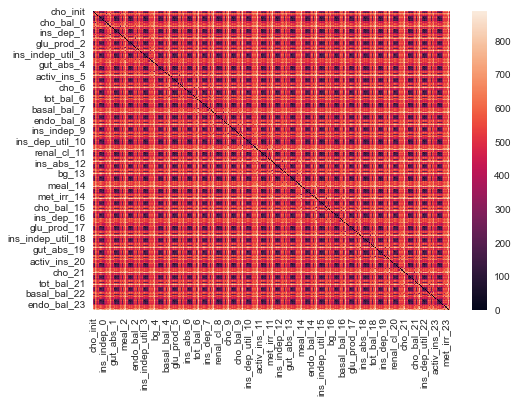

In [10]:
sns.heatmap(df_distance)

In [ ]:
groups = []
